In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path
from typing import Union, Dict, Optional, List, Tuple
from collections import defaultdict
import warnings
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.cluster as spc
from tqdm import tqdm

from camelsml.metrics import calc_nse
from camelsml.datautils import load_attributes
from camelsml import load_config
from camelsml.utils import get_basin_list

# This notebook contains results from our attempt at reducing static features.

In [3]:
def correlation(
    attributes: pd.DataFrame, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    corr = attributes.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.7747, 4.7747))
    ax.tick_params(axis="both", which="both", labelsize=5)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.1,
        cbar_kws={"shrink": 0.5},
        ax=ax,
    )
    ax.xaxis.label.set_size(5)
    ax.yaxis.label.set_size(0)
    if title is not None:
        ax.set_title(title)

In [4]:
def dendrogram(
    attributes: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
) -> np.ndarray:
    # Using the absolute value Pearson correlations.
    corr = attributes.corr().abs()
    corr_linkage = spc.hierarchy.ward(corr)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    dendro = spc.hierarchy.dendrogram(
        corr_linkage, ax=ax, orientation="left", labels=attributes.columns
    )
    return corr_linkage


def feature_reduction(
    corr_linkage: np.ndarray, level: int, labels: np.ndarray
) -> np.ndarray:
    cluster_ids = spc.hierarchy.fcluster(corr_linkage, level, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return labels[selected_features]

In [5]:
# This cell is messed up now
"""cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")
db_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"
basins = get_basin_list(cfg["train_basin_file"])
attributes = load_attributes(
    db_path=db_path,
    basins=basins,
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))
axes = axes.flatten()
correlation(attributes, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
corr_linkage = dendrogram(attributes, ax=axes[0])
# axes[0].set_yticks([])
# axes[0].set_xticks([])
fig.tight_layout()
fig.savefig(
    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"
)"""

'cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")\ndb_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"\nbasins = get_basin_list(cfg["train_basin_file"])\nattributes = load_attributes(\n    db_path=db_path,\n    basins=basins,\n)\nfig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))\naxes = axes.flatten()\ncorrelation(attributes, ax=axes[1])\naxes[1].set_xticks([])\naxes[1].set_yticks([])\ncorr_linkage = dendrogram(attributes, ax=axes[0])\n# axes[0].set_yticks([])\n# axes[0].set_xticks([])\nfig.tight_layout()\nfig.savefig(\n    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"\n)'

In [6]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str], k, model_type: str, seed: int, epoch: int = 30
) -> Dict:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    return full_results

In [7]:
def restructure_results(nse_values: Dict) -> np.ndarray:
    results = []
    for i, epoch in enumerate(nse_values.keys()):
        results.append(np.array(list(nse_values[epoch].values())))
    results = np.array(results).T
    return results


def nse_boxplots(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.boxplot(nse_values, showmeans=True)
    ax.set_ylabel("NSE")
    ax.grid()
    epochs = nse_values.shape[1] + 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    if title is not None:
        ax.set_title(title)


def plot_median_average(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
) -> Tuple[plt.Line2D, plt.Line2D]:
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    line_mean = ax.plot(epochs, nse_values.mean(axis=0), label="mean")[0]
    line_median = ax.plot(epochs, np.median(nse_values, axis=0), label="median")[0]
    # ax.set_ylim([0, 1])
    # ax.set_xlabel("Epoch")
    # ax.set_ylabel("NSE")
    ax.grid()
    # ax.legend()
    if title is not None:
        ax.set_title(title)
    return line_mean, line_median


def plot_fractions(
    nse_values: np.ndarray,
    good_model: float = 0.7,
    title: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    basins = nse_values.shape[0]
    frac = []
    for i, epoch in enumerate(nse_values.T):
        frac.append(len(epoch[epoch > good_model]))
        frac[i] /= basins
    ax.plot(epochs, frac)
    ax.set_xlabel("Epoch")
    # ax.set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
    ax.grid()
    if title is not None:
        ax.set_title(title)

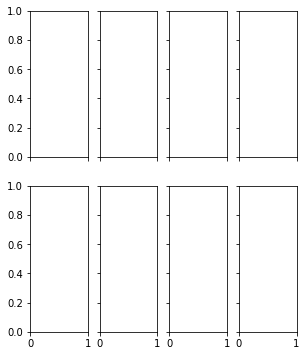

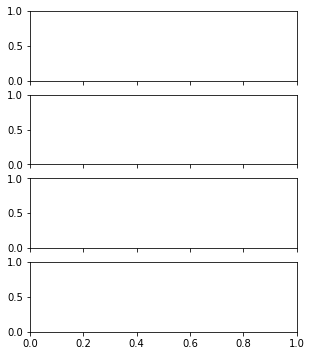

In [8]:
fig_runs_plots, axes_runs_plots = plt.subplots(
    2, 4, figsize=[4.7747, (4.7747 / 1.618) * 2], sharey=True, sharex=True
)
fig_runs_boxplots, axes_runs_boxplots = plt.subplots(
    4, 1, figsize=[4.7747, (4.7747 / 1.618) * 2], sharex=True, sharey=True
)

In [9]:
good_model = 0.7
results_full_features = load_results(
    "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204",
    "ealstm",
    19970204,
)
nse_values_full = restructure_results(results_full_features)
title_full = "76 features"
nse_boxplots(
    nse_values_full,
    ax=axes_runs_boxplots[0],
    title=title_full,
)
plot_median_average(nse_values_full, ax=axes_runs_plots[0, 0], title=title_full)
plot_fractions(nse_values_full, good_model=good_model, ax=axes_runs_plots[1, 0])

## Removing 20 features by setting the treshold to 9.3

This will be used to train a new model

In [10]:
keep = feature_reduction(corr_linkage, level=0.93, labels=attributes.columns.to_numpy())
np.savetxt(
    "../runs/correlation_reduction/20_less_features/use_features.txt", keep, fmt="%s"
)
fig_corr_56, axes_corr_56 = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes_corr_56.flatten()
reduced_attributes_20 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_20, ax=axes_corr_56[0])
corr_linkage_20_less = dendrogram(reduced_attributes_20, ax=axes_corr_56[1])
fig_corr_56.tight_layout()

NameError: name 'corr_linkage' is not defined

In [ ]:
results_56_features = load_results(
    "../runs/correlation_reduction/20_less_features/run_1512_0054_seed19970204",
    "ealstm",
    19970204,
)
title_56_features = "56 features"
nse_values_56_features = restructure_results(results_56_features)
nse_boxplots(nse_values_56_features, ax=axes_runs_boxplots[1], title=title_56_features)
plot_median_average(
    nse_values_56_features, title=title_56_features, ax=axes_runs_plots[0, 1]
)
plot_fractions(nse_values_56_features, ax=axes_runs_plots[1, 1])

In [ ]:
keep = feature_reduction(
    corr_linkage_20_less, level=1.15, labels=reduced_attributes_20.columns.to_numpy()
)
np.savetxt(
    "../runs/correlation_reduction/40_less_features/use_features.txt", keep, fmt="%s"
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes.flatten()
reduced_attributes_40 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_40, ax=axes[0])
corr_linkage_40_less = dendrogram(reduced_attributes_40, ax=axes[1])
fig.tight_layout()
print(reduced_attributes_40.shape)

In [ ]:
results_36_features = load_results(
    "../runs/correlation_reduction/40_less_features/run_1512_1507_seed19970204",
    "ealstm",
    19970204,
)
title_36_features = "36 features"
nse_values_36_features = restructure_results(results_36_features)
nse_boxplots(nse_values_36_features, ax=axes_runs_boxplots[2], title=title_36_features)
plot_median_average(
    nse_values_36_features, title=title_36_features, ax=axes_runs_plots[0, 2]
)
plot_fractions(nse_values_36_features, ax=axes_runs_plots[1, 2])

## No features

In [ ]:
results_no_features = load_results(
    "../runs/correlation_reduction/no_features/run_1612_0909_seed19970204",
    "lstm_no_static",
    19970204,
)
title_no_features = "no features"
nse_values_no_features = restructure_results(results_no_features)
nse_boxplots(nse_values_no_features, title=title_no_features, ax=axes_runs_boxplots[3])
line_mean, line_median = plot_median_average(
    nse_values_no_features, title=title_no_features, ax=axes_runs_plots[0, 3]
)
plot_fractions(nse_values_no_features, ax=axes_runs_plots[1, 3])

In [ ]:
axes_runs_plots[0, 0].set_ylabel("NSE")
axes_runs_plots[1, 0].set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
axes_runs_plots[1, 1].set_xlabel("Epochs")
axes_runs_plots[0, 0].set_ylim([0, 1])
fig_runs_plots.legend(handles=[line_mean, line_median])
fig_runs_plots.tight_layout()
axes_runs_boxplots[0].set_ylim([0, 1])
axes_runs_boxplots[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axes_runs_boxplots[3].set_xlabel("Epochs")
fig_runs_boxplots.tight_layout()
fig_runs_boxplots.savefig("boxplots.pdf")
fig_runs_plots.savefig("plots.pdf")
fig_runs_plots

In [ ]:
fig_runs_boxplots

Forcing -> Physical model  (EXISTS FOR US)  -> Prediction 

                                                            -> Improved prediction 
                                                            
Forcing + static features -> Lstm model     -> Prediction 

In [ ]:
test = load_results(
    "../runs/correlation_reduction/chosen_features/run_2312_2011_seed19970204",
    "ealstm",
    19970204,
)
test_nse = restructure_results(test)
nse_boxplots(
    test_nse,
)
plt.ylim([0, 1])
plt.savefig("boxplot_manual_features.pdf")
plt.show()
plot_fractions(test_nse)
plt.ylabel("Fraction NSE > 0.7")
plt.savefig("fractions_manual_features.pdf")
plt.show()

In [12]:
results_chosen_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv",
    5,
    "ealstm",
    "19970204",
    epoch=14,
)
results_chosen_and_position_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_with_position_cv",
    5,
    "ealstm",
    "19970204",
)
results_chosen_concat_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_concat_cv",
    5,
    "lstm",
    "19970204",
)
results_no_features_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/no_features_cv",
    5,
    "lstm_no_static",
    "19970204",
)
results_all_features_fixed_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv",
    5,
    "ealstm",
    "19970204",
)
chosen_cv_nse = restructure_results(results_chosen_cv)
chosen_with_pos_cv_nse = restructure_results(results_chosen_and_position_cv)
chosen_concat_cv_nse = restructure_results(results_chosen_concat_cv)
no_features_cv_nse = restructure_results(results_no_features_cv)
all_features_fixed_cv_nse = restructure_results(results_all_features_fixed_cv)

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


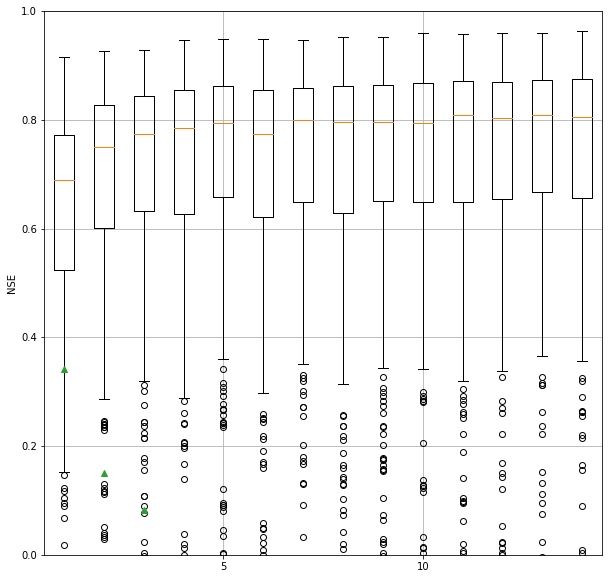

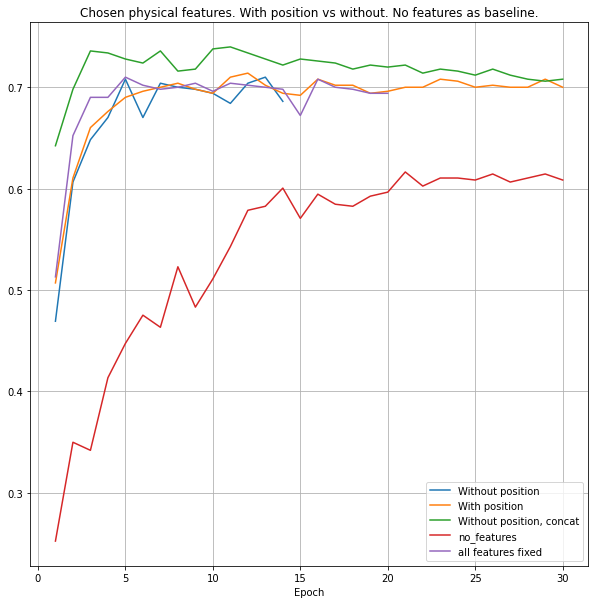

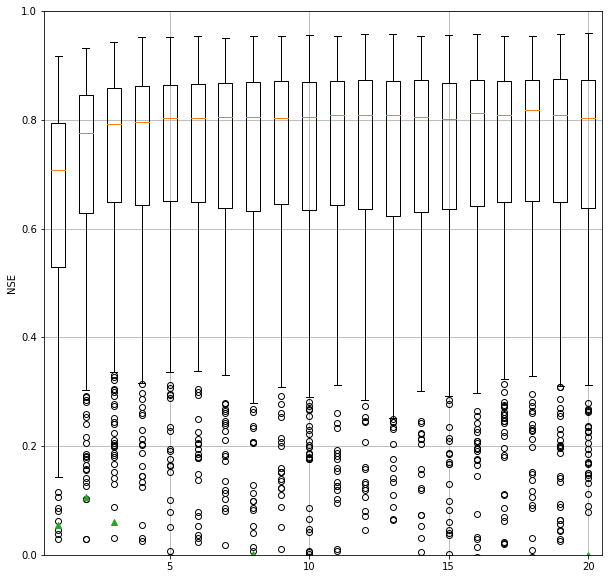

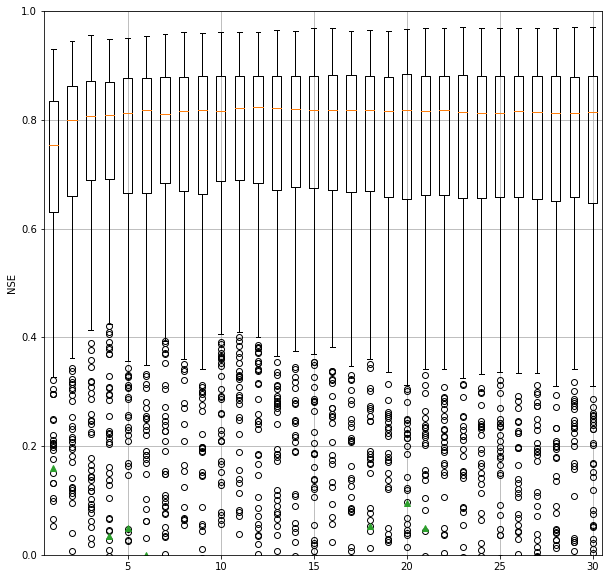

In [20]:
nse_boxplots(chosen_cv_nse)
plt.ylim([0, 1])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_fractions(chosen_cv_nse, ax=ax)
plot_fractions(chosen_with_pos_cv_nse, ax=ax)
plot_fractions(chosen_concat_cv_nse, ax=ax)
plot_fractions(no_features_cv_nse, ax=ax)
plot_fractions(all_features_fixed_cv_nse, ax=ax)
ax.legend(
    [
        "Without position",
        "With position",
        "Without position, concat",
        "no_features",
        "all features fixed",
    ]
)
ax.set_title(
    "Chosen physical features. With position vs without. No features as baseline."
)
plt.show()
nse_boxplots(all_features_fixed_cv_nse)
plt.ylim([0, 1])
plt.show()
nse_boxplots(chosen_concat_cv_nse)
plt.ylim([0, 1])
plt.show()

In [ ]:
results_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv",
    5,
    "ealstm",
    "19970204",
)
cv_nse = restructure_results(results_cv)
nse_boxplots(
    cv_nse,
)
plt.ylim([0, 1])
plt.show()
plot_fractions(cv_nse)

In [ ]:
results_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/20_less_features_cv",
    5,
    "ealstm",
    "19970204",
)
cv_nse = restructure_results(results_cv)
nse_boxplots(
    cv_nse,
)
plt.ylim([0, 1])
plt.show()
plot_fractions(cv_nse)